In [1]:
## Standard imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import os
import json
import torch
import astroddpm
import tqdm.notebook as tqdm

## Relative imports
from astroddpm.runners import Diffuser, config_from_id, get_samples
from astroddpm.analysis.validationMetrics import powerSpectrum, minkowskiFunctional, basics
from astroddpm.analysis import overfitting_check
from astroddpm.utils.plot import check_nearest_epoch, plot_losses, check_training_samples, plot_comparaison
from astroddpm.diffusion.dm import DiscreteSBM
from astroddpm.diffusion.stochastic.sde import DiscreteVPSDE
from astroddpm.diffusion.stochastic.solver import get_schedule
from astroddpm.diffusion.models.network import ResUNet
import astroddpm.utils.colormap_custom 

/mnt/sw/nix/store/pvz51gzx2lyqpabf08xhd1y2kvw5rfdy-python-3.9.16-view/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/mnt/sw/nix/store/d9jbiy4kghz72ak7mija92asihk8xcja-py-torchvision-0.15.2/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
ALL_MODELS = os.path.join(os.path.dirname(astroddpm.__file__), 'config', 'MODELS.json')

with open(ALL_MODELS, 'r') as f:
    ALL_MODELS_DICT = json.load(f)
print(ALL_MODELS_DICT.keys())

dict_keys(['DiscreteSBM_ND_SigmaVPSDE_MHD_BPROJ_N_4000_bottleneck_32', 'DiscreteSBM_ND_SigmaVPSDE_MHD_BPROJ_N_1000_bottleneck_16', 'DiscreteSBM_ND_SigmaVPSDE_MHD_BPROJ_N_4000_bottleneck_16', 'DiscreteSBM_ND_VPSDE_MHD_BPROJ_N_1000_bottleneck_32', 'DiscreteSBM_ND_VPSDE_MHD_BPROJ_N_1000_bottleneck_16', 'DiscreteSBM_ND_SigmaVPSDE_MHD_BPROJ_N_8000_bottleneck_16', 'DiscreteSBM_ND_VPSDE_MHD_BPROJ_N_4000_bottleneck_32', 'DiscreteSBM_ND_SigmaVPSDE_MHD_BPROJ_N_8000_bottleneck_32', 'DiscreteSBM_ND_VPSDE_MHD_BPROJ_N_4000_bottleneck_16', 'DiscreteSBM_ND_VPSDE_MHD_BPROJ_N_8000_bottleneck_32', 'DiscreteSBM_ND_VPSDE_MHD_BPROJ_N_8000_bottleneck_16', 'DiscreteSBM_ND_SigmaVPSDE_MHD_BPROJ_N_1000_bottleneck_32', 'DiscreteSBM_ND_SigmaVPSDE_MHD_BPROJ_N_4000_bottleneck_32_betamin_0.01_step', 'DiscreteSBM_ND_SigmaVPSDE_MHD_BPROJ_N_4000_bottleneck_32_betamin_0.05_invsqrt', 'DiscreteSBM_ND_SigmaVPSDE_MHD_BPROJ_N_1000_bottleneck_16_betamin_0.05_step', 'DiscreteSBM_ND_SigmaVPSDE_MHD_BPROJ_N_4000_bottleneck_32_beta

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
amin = - 3
amax = 6

MODEL_ID = 'ContinuousSBM_ContinuousVPSDE_I_BPROJ_bottleneck_16_firstc_6_phi_beta_cosine'
MODEL_ID = 'ContinuousSBM_ContinuousVPSDE_I_BPROJ_bottleneck_32_firstc_10_phi_beta_cosine_betamax_0.5_betamin_0.001'
MODEL_ID = 'ContinuousSBM_FFResUNet_bottleneck_32_firstc_10_phi_beta_cosine_betamax_2.0_betamin_0.01'
#MODEL_ID = 'ContinuousSBM_bottleneck_32_firstc_10_phi_beta_cosine_betamax_2.0_betamin_0.01'

In [14]:
config = config_from_id(MODEL_ID)
if 'FFResUNet' in MODEL_ID:
    print('FFResUNet')
    config['diffusion_model']['network']['type']='FFResUNet'
    config['diffusion_model']['network']['in_c']=1

FFResUNet


In [15]:
placeholder_dm = DiscreteSBM(DiscreteVPSDE(1000), ResUNet())
diffuser = Diffuser(placeholder_dm)
diffuser.load(config=config, also_ckpt=True, for_training=True)

No model id found
Loading the diffuser from a config dict.
{'in_c': 1, 'out_c': 1, 'first_c': 10, 'sizes': [256, 128, 64, 32], 'num_blocks': 1, 'n_steps': 1000, 'time_emb_dim': 100, 'dropout': 0, 'attention': [], 'normalisation': 'GN', 'padding_mode': 'circular', 'eps_norm': 1e-05, 'skiprescale': True, 'type': 'FFResUNet', 'discretization': 'continuous', 'embedding_mode': 'fourier', 'has_phi': True, 'phi_shape': 2, 'phi_embed_dim': 100, 'n_ff_min': 6, 'n_ff_max': 8}
Loading the optimizer and scheduler states from the checkpoint, as well as previous training info. You should change the model id if you want to finetune the model.


In [16]:
np.mean(diffuser.losses[-1000:])

0.4235632353127003

## Losses

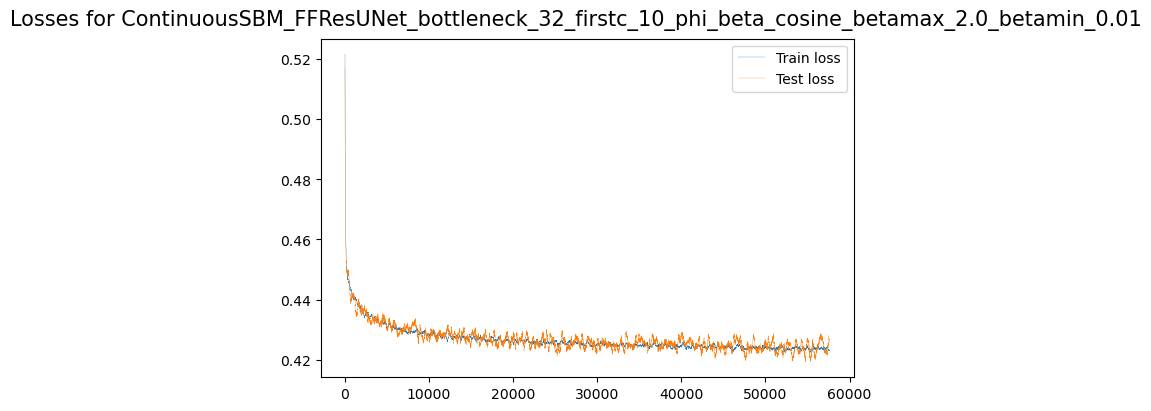

In [17]:
plot_losses(diffuser, burnin=0, linewidth=0.2, running_mean=200, figsize=(6,4))

In [11]:
diffuser.diffmodel.sde.beta_T = 0.5
diffuser.diffmodel.sde.noise_level(torch.ones(1))

tensor([0.5335])

## Results visualization

Nearest epoch found is 200


Summing over the first dimensions


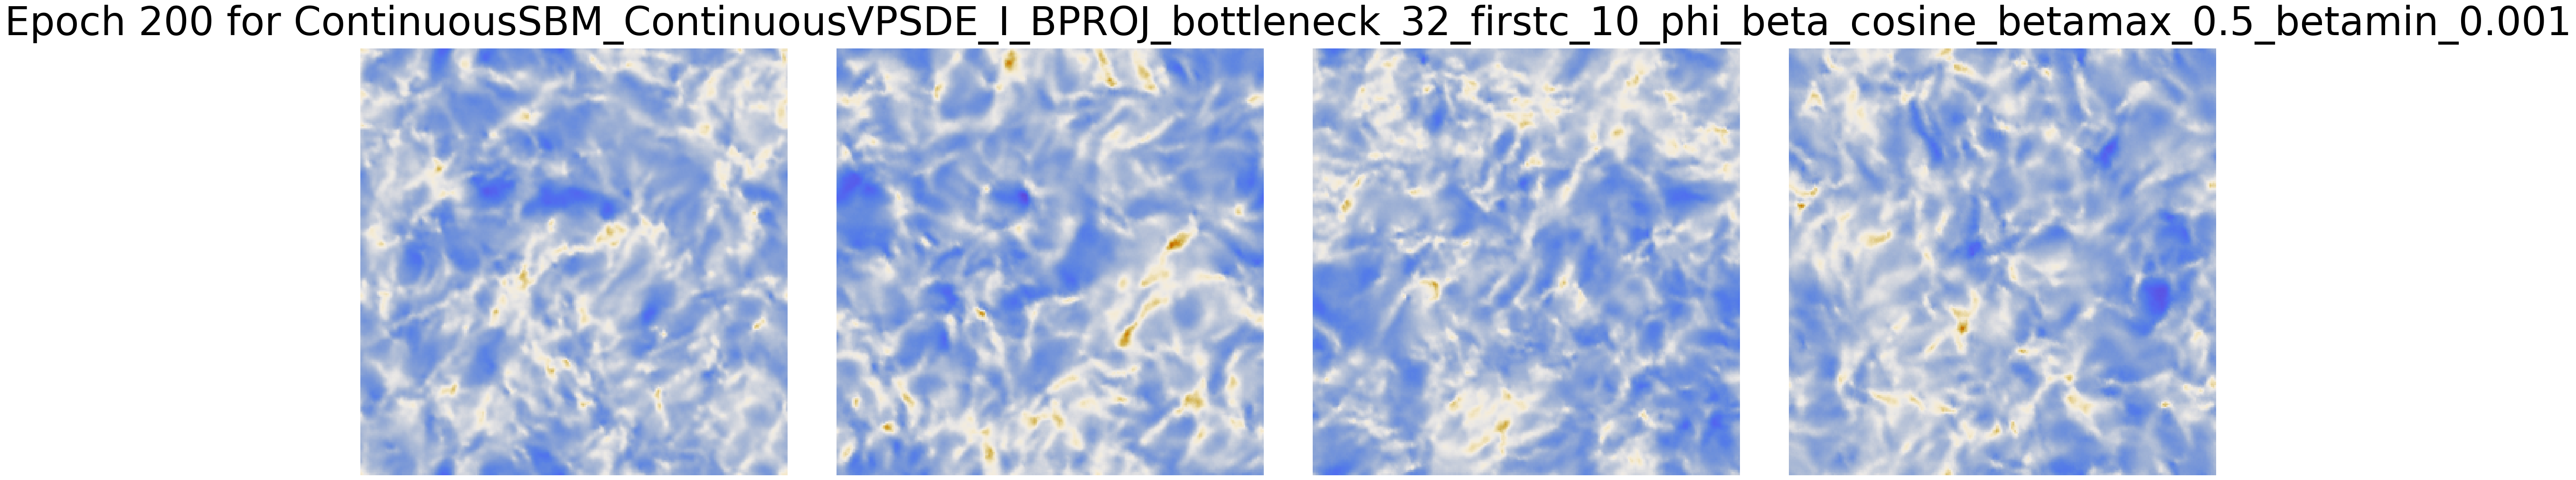

In [12]:
check_nearest_epoch(diffuser, 100, max_to_plot=4, amin = -3, amax = 6)

In [13]:
plot_comparaison(diffuser, 4, elementary_figsize=(6,6), amin = -3, amax = 6)

IndexError: list index out of range

## Summary statistics

### Basics

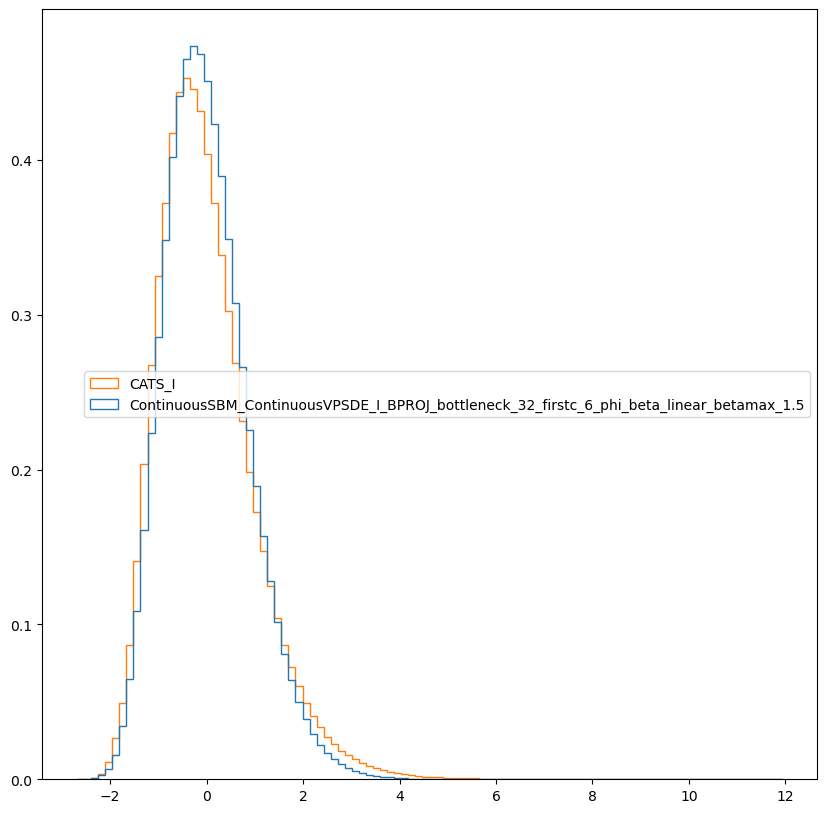

In [ ]:
basics.plot_hist_samples_dataset(diffuser, max_num_samples=100)

In [ ]:
basics.wasserstein(diffuser, max_num_samples=100)

0.010767624065579618

### Power Spectrum

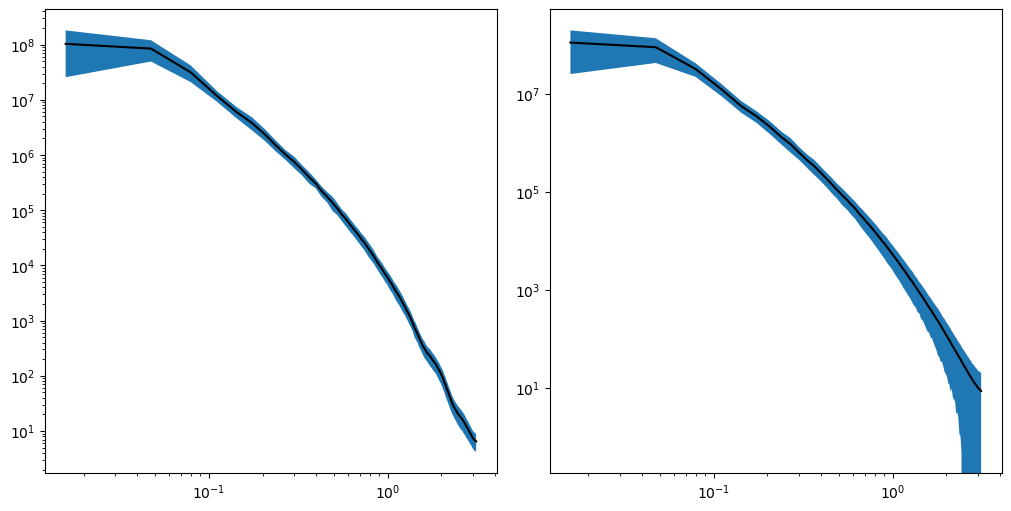

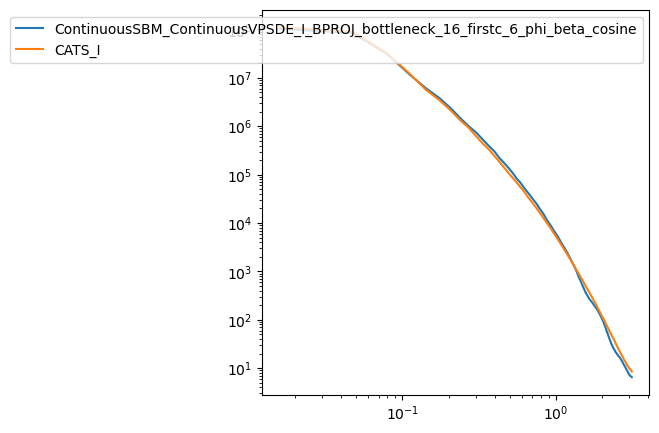

In [ ]:
mean_list, std_list, bins_centers, labels = powerSpectrum.plot_ps_samples_dataset(diffuser, max_num_samples=128, use_gpu=False)

In [ ]:
#mean_list, std_list, bins_centers, labels = powerSpectrum.plot_sets_power_spectrum_iso2d([batch, samples])

In [ ]:
# $samples = get_samples(diffuser)
# samples = torch.from_numpy(samples)
# samples2 = torch.roll(samples, [10,10], dims=[2,3])

# samples = torch.cat([samples, samples2], dim=1).to(device)
# samples.shape

In [ ]:
#power_spectra, mean_, std_, bins = powerSpectrum.set_power_spectrum_iso2d(samples, bins = torch.linspace(0, np.pi, 100), only_stat = False)

In [ ]:
#power_spectra.shape

In [ ]:
#mean, std, bins = powerSpectrum.plot_set_power_spectrum_iso2d(samples, elementary_figsize = (3, 3), show = True)

In [ ]:
#mean_list, bins_centers, labels, _ = powerSpectrum.plot_sets_power_spectrum_iso2d([samples, samples], elementary_figsize = (7, 7), labels=['sample', 'sample'])

In [ ]:
mean_list = [mean.cpu().numpy() for mean in mean_list]
std_list = [std.cpu().numpy() for std in std_list]

### Minkowski functionnals

In [ ]:
samples = basics.get_samples(diffuser)
l_samples = np.split(samples, len(samples), axis=0)
l_samples = [l_samples[i][0][0] for i in range(len(l_samples))]

dataset = diffuser.train_dataloader.dataset

num_dataset_samples = 128

l_dataset = [dataset[i].numpy().copy(order = 'C') for i in range(num_dataset_samples)]

try:
    labels_diffuser = diffuser.config["model_id"]
    raise Exception("Not implemented")
except:
    labels_diffuser = "Samples"

try:
    labels_dataset = diffuser.config["dataloaders"]["dataset"]["name"]
    raise Exception("Not implemented")
except:
    labels_dataset = "Original"

range_min = -8

range_max = 8


In [ ]:
# l_samples = torch.split(samples, 1, dim=0)
# l_samples = [l_samples[i][0][0].detach().cpu().numpy() for i in range(len(l_samples))]

# l_dataset = [batch[i,0].detach().cpu().numpy() for i in range(len(batch))]

# try:
#     labels_diffuser = diffuser.config["model_id"]
#     raise Exception("Not implemented")
# except:
#     labels_diffuser = "Samples"

# try:
#     labels_dataset = diffuser.config["dataloaders"]["dataset"]["name"]
#     raise Exception("Not implemented")
# except:
#     labels_dataset = "Original"

# range_min = -8

# range_max = 8

In [ ]:
smm, sms=minkowskiFunctional.plot_mink_functionals([l_dataset,l_samples],gs_vals = np.linspace(range_min, range_max, 200),
          names = [labels_dataset, labels_diffuser], cols = ['b', 'r'], 
          savefig_dict={})

(array([-10.,  -8.,  -6.,  -4.,  -2.,   0.,   2.,   4.,   6.,   8.,  10.]),
 [Text(-10.0, 0, '−10'),
  Text(-8.0, 0, '−8'),
  Text(-6.0, 0, '−6'),
  Text(-4.0, 0, '−4'),
  Text(-2.0, 0, '−2'),
  Text(0.0, 0, '0'),
  Text(2.0, 0, '2'),
  Text(4.0, 0, '4'),
  Text(6.0, 0, '6'),
  Text(8.0, 0, '8'),
  Text(10.0, 0, '10')])

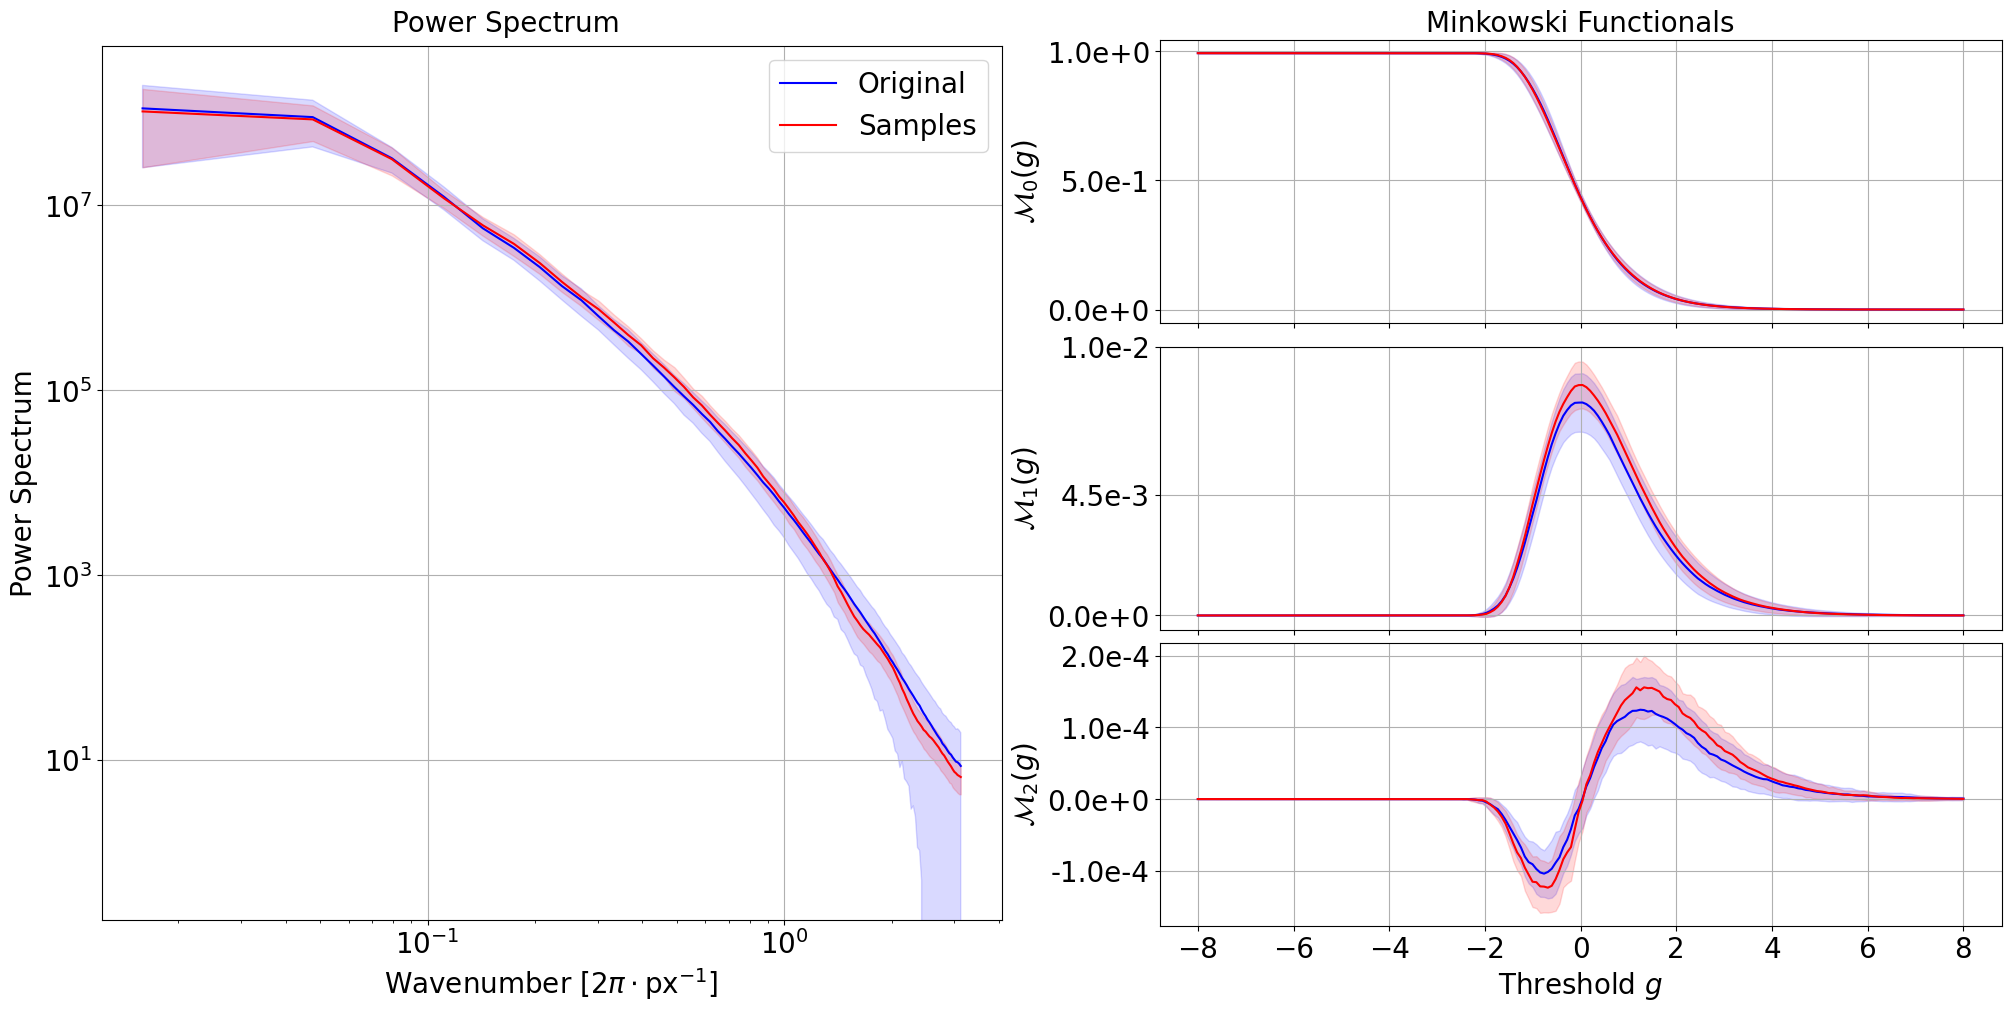

In [ ]:
## Plot side by side, on the left the power spectra with mean and std and on the right the minkowski functionals with mean and std
fontsize = 20
alpha = 0.15
grid = True
fig, ax = plt.subplots(figsize=(20, 10), layout = 'constrained')

subfig = fig.subfigures(1, 2, wspace=0.0)

# Plot power spectra
ax_left = subfig[0].subplots(1, 1)
mean_list = mean_list[::-1]
std_list = std_list[::-1]

ax_left.plot(bins_centers, mean_list[0][:-1], color='b', label='Original')
ax_left.fill_between(bins_centers, mean_list[0][:-1] - std_list[0][:-1], mean_list[0][:-1] + std_list[0][:-1], alpha=alpha, color='b')

ax_left.plot(bins_centers, mean_list[1][:-1], color = 'r', label='Samples')
ax_left.fill_between(bins_centers, mean_list[1][:-1] - std_list[1][:-1], mean_list[1][:-1] + std_list[1][:-1], alpha=alpha, color='r')

ax_left.set_xlabel('Wavenumber [$2\pi\cdot\mathrm{px}^{-1}$]', fontsize=20)
ax_left.set_ylabel('Power Spectrum', fontsize=20)

ax_left.legend(prop={'size': 20})
ax_left.set_xscale('log')
ax_left.set_yscale('log')
ax_left.grid(grid)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
subfig[0].suptitle('Power Spectrum', fontsize=20)

# Plot minkowski functionals
## Create three subplots sharing the x axis

def format_ticks(value, tick_number):
    return "{:.1e}".format(value).replace("e+0", "e+").replace("e-0", "e-")

ax_right = subfig[1].subplots(3, 1, sharex=True)

ax_right[0].plot(np.linspace(range_min, range_max, 200), smm[0][:, 0], color='b')
ax_right[0].fill_between(np.linspace(range_min, range_max, 200), smm[0][:, 0] - sms[0][:, 0], smm[0][:, 0] + sms[0][:, 0], alpha=alpha, color='b')

ax_right[0].plot(np.linspace(range_min, range_max, 200), smm[1][:, 0], color='r')
ax_right[0].fill_between(np.linspace(range_min, range_max, 200), smm[1][:, 0] - sms[1][:, 0], smm[1][:, 0] + sms[1][:, 0], alpha=alpha, color='r')

ax_right[0].set_ylabel('$\mathcal{M}_{0}(g)$', fontsize=20)
ax_right[0].set_title('Minkowski Functionals', fontsize=20)
ax_right[0].set_yticks([0 ,0.5, 1], labels =[0 ,0.5, 1] ,fontsize=20)
ax_right[0].yaxis.set_major_formatter(ticker.FuncFormatter(format_ticks))

ax_right[1].plot(np.linspace(range_min, range_max, 200), smm[0][:, 1], color='b')
ax_right[1].fill_between(np.linspace(range_min, range_max, 200), smm[0][:, 1] - sms[0][:, 1], smm[0][:, 1] + sms[0][:, 1], alpha=alpha, color='b')

ax_right[1].plot(np.linspace(range_min, range_max, 200), smm[1][:, 1], color='r')
ax_right[1].fill_between(np.linspace(range_min, range_max, 200), smm[1][:, 1] - sms[1][:, 1], smm[1][:, 1] + sms[1][:, 1], alpha=alpha, color='r')

ax_right[1].set_ylabel('$\mathcal{M}_{1}(g)$', fontsize=20)
ax_right[1].set_yticks([0 ,4.5e-3, 1e-2], labels =[0 ,4.5e-3, 1e-2] ,fontsize=20)
ax_right[1].yaxis.set_major_formatter(ticker.FuncFormatter(format_ticks))

ax_right[2].plot(np.linspace(range_min, range_max, 200), smm[0][:, 2], color='b')
ax_right[2].fill_between(np.linspace(range_min, range_max, 200), smm[0][:, 2] - sms[0][:, 2], smm[0][:, 2] + sms[0][:, 2], alpha=alpha, color='b')

ax_right[2].plot(np.linspace(range_min, range_max, 200), smm[1][:, 2], color='r')
ax_right[2].fill_between(np.linspace(range_min, range_max, 200), smm[1][:, 2] - sms[1][:, 2], smm[1][:, 2] + sms[1][:, 2], alpha=alpha, color='r')

ax_right[2].set_ylabel('$\mathcal{M}_{2}(g)$', fontsize=20)
ax_right[2].set_xlabel('Threshold $g$', fontsize=20)
ax_right[2].tick_params(axis='y', which='major', labelsize=20)
ax_right[2].yaxis.set_major_formatter(ticker.FuncFormatter(format_ticks))
for ax in ax_right:
    ax.grid(grid)

plt.xticks(fontsize=20)

## Overfitting check

In [26]:
BORDER_PERIODIC = True ## Computations will change depending on the boundary conditions, for non border periodic, L2 distance is enough, for border periodic, we need to use the distance in Fourrier space to account for the symetry of the problem ONLY TRUE for now in the package.

#### Diversity of samples check

- Check the samples against one another (and compute some metrics on it as well as plot the closest samples)
- Check the samples against data points

For border periodic fields, all these computations will be up to a translation of a vector $\vec{r}$

In [ ]:
overfitting_check.plot_closest_pairs_samples_dataset(diffuser)

Sanity check, images should be the same in the top and bottom rows.

In [ ]:
samples = get_samples(diffuser)
samples = torch.from_numpy(samples)
samples.unsqueeze(1)
overfitting_check.plot_closest_pairs_sanity_check(samples) ##Input a batch of shape B C H W

## ODE SAMPLING

In [29]:
gen = diffuser.diffmodel.ode_sampling(16)

NotImplementedError: Not implemented yet

In [ ]:
## Plot the samples

fig, axs = plt.subplots(1, 4, figsize=(10,10), layout = 'constrained')
for i in range(4):
        axs[i].imshow(gen[i][0].cpu().numpy(), vmin = amin, vmax = amax)
        axs[i].axis('off')


In [ ]:
def forward_ode_sampling(diffuser, sample):
    diffuser.diffmodel.eval()
    gen = sample.to(device).clone()
    with torch.no_grad():
        progress_bar = tqdm.tqdm(total=diffuser.diffmodel.sde.N)
        for i in range(diffuser.diffmodel.sde.N):
            timesteps = torch.tensor([i]).repeat(len(sample)).to(device)
            modified_score = diffuser.diffmodel.network(gen, timesteps)
            gen -= diffuser.diffmodel.sde.ode_drift(gen, timesteps, modified_score)
            progress_bar.update(1)
    return gen

In [ ]:
forward_gen = forward_ode_sampling(diffuser, image)

  0%|          | 0/4000 [00:00<?, ?it/s]

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(40,10), layout = 'constrained')
axs[0].imshow(image[0][0].cpu().numpy(), vmin = -3, vmax = 3, cmap = 'cmb')
axs[0].axis('off')
axs[1].imshow(forward_gen2[0][0].cpu().numpy(), vmin = -3, vmax = 3, cmap = 'cmb')
axs[1].axis('off')
axs[2].imshow(forward_gen[0][0].cpu().numpy(), vmin = -3, vmax = 3, cmap = 'cmb')
axs[2].axis('off')
axs[3].imshow((forward_gen-forward_gen2)[0][0].cpu().numpy(), vmin = -3, vmax = 3, cmap = 'cmb')
axs[3].axis('off')

In [ ]:
plt.hist(forward_gen.cpu().numpy().flatten(), bins=100, range=(-6,6), density=True, histtype='step', label='ODE')
plt.show()

In [ ]:
forward_gen[3].mean(), forward_gen[3].std()

(tensor(0.0509, device='cuda:0'), tensor(0.9286, device='cuda:0'))

In [ ]:
diffuser.diffmodel.sde.ddpm_math

True

In [ ]:
model = diffuser.diffmodel

In [ ]:
sample = model.generate_image(1)
#sample = next(iter(diffuser.test_dataloader))
#sample = sample[:1].to(device).unsqueeze(1)

100%|██████████| 1000/1000 [00:05<00:00, 169.06it/s]


In [ ]:
ll, pll, lls, gen2 = model.log_likelihood(sample.detach(), initial_timestep=0, repeat=1)

100%|██████████| 1000/1000 [00:14<00:00, 67.77it/s]


In [ ]:
timestep = 200 * torch.ones(1, dtype=torch.long)
sample_t, _, _ = model.sde.sampling(image, timestep, sq_ps)

In [ ]:
plt.imshow(sample_t.detach().cpu()[0,0])

In [ ]:
likelihoods = []
times = range(170, 250, 10)
for t in times:
    ll, _, _, _ = model.log_likelihood(sample_t.detach(), initial_timestep=t, repeat=100)
    likelihoods.append(ll.detach())

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].plot(times, [l.detach().cpu().item()/256**2/np.log(2) for l in likelihoods])
ax[1].plot(times,torch.nn.functional.softmax(torch.tensor([l[0].detach().cpu().item() for l in likelihoods])))